In [43]:
import IPython
from IPython.display import Audio
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from datetime import timedelta
import pandas as pd
import cv2
import IPython.display as Disp
from ipywidgets import widgets
%matplotlib inline

In [44]:
from PyQt5.QtWidgets import QApplication, QDialog
from PyQt5.QtCore import QCoreApplication

#app = QApplication(sys.argv)
app = QCoreApplication.instance()
if app is None:
    app = QApplication(sys.argv)

In [45]:
#from https://timsainburg.com/noise-reduction-python.html
#This functions implement a gated spectral noise filter
import time
from datetime import timedelta as td

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)
def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)
def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x,ref=1.0)
def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20,4))
    cax = ax.matshow(signal, origin = 'lower', aspect='auto', cmap=plt.cm.seismic, vmin=-1*np.max(np.abs(signal)), vmax=np.max(np.abs(signal)))
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [46]:
#Upload the field data
wav_loc = "template1.mp3"
xenocanto,sr= librosa.load(wav_loc)
#data1 = data1/32768
#mytime = np.arange(0, len(data1)/rate, 1/rate)
#len(mytime)==len(data1)

/usr/local/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [48]:
#Here's what the raw data sounds like
Audio(xenocanto[0:15*sr],rate=sr)

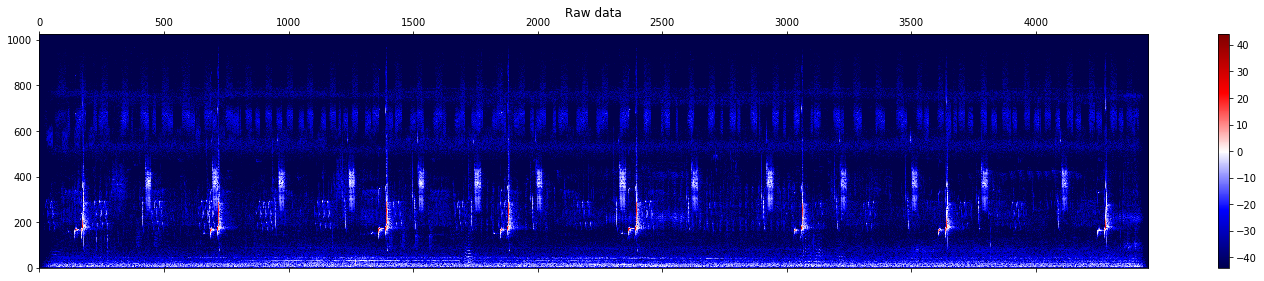

In [49]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(xenocanto)
y_pad = librosa.util.fix_length(xenocanto,n + n_fft //2)
xenocanto_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
xenocanto_stft_db = _amp_to_db(np.abs(xenocanto_stft))# convert to dB
plot_spectrogram(xenocanto_stft_db, title='Raw data')

In [10]:
#im=cv2.flip(xenocanto_stft_db, 0)

In [66]:
%matplotlib qt
#Select box
#push enter
#push esc
r = cv2.selectROI(im)

In [76]:
r[1]

694

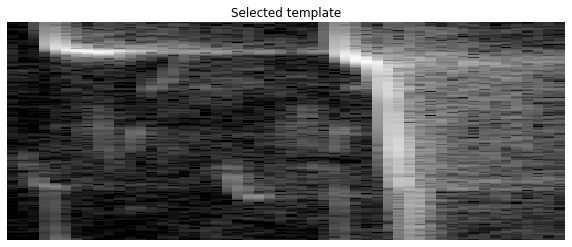

In [67]:
%matplotlib inline
imCrop = im[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
#imCrop=cv2.flip(imCrop,0)
fig, ax = plt.subplots(figsize=(10,4))
ax.imshow(imCrop, cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('Selected template')
plt.show()

In [77]:
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(imCrop,im[r[1]-10:r[1]+r[3]+10],5)
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.6)
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000, hop_length=hop_length)

In [78]:
df=pd.DataFrame({'times':call_times,'x':x,'y':y,'corr':result[x,y]});
df=df.sort_values('times')

In [79]:
idx=np.where(np.diff(call_times)>0.03)
df=df.loc[(np.diff(np.append(df.times,np.inf))>0.03)].copy()
df=df.reset_index(drop=True)
df

,times,x,y,corr
0,2.986667,10,140,0.819502
1,14.570667,10,683,0.728561
2,28.949333,10,1357,0.832814
3,39.402667,10,1847,1.000000
4,50.346667,10,2360,0.817528
5,64.533333,13,3025,0.805407
6,76.906667,10,3605,0.833217
7,90.517333,13,4243,0.829249


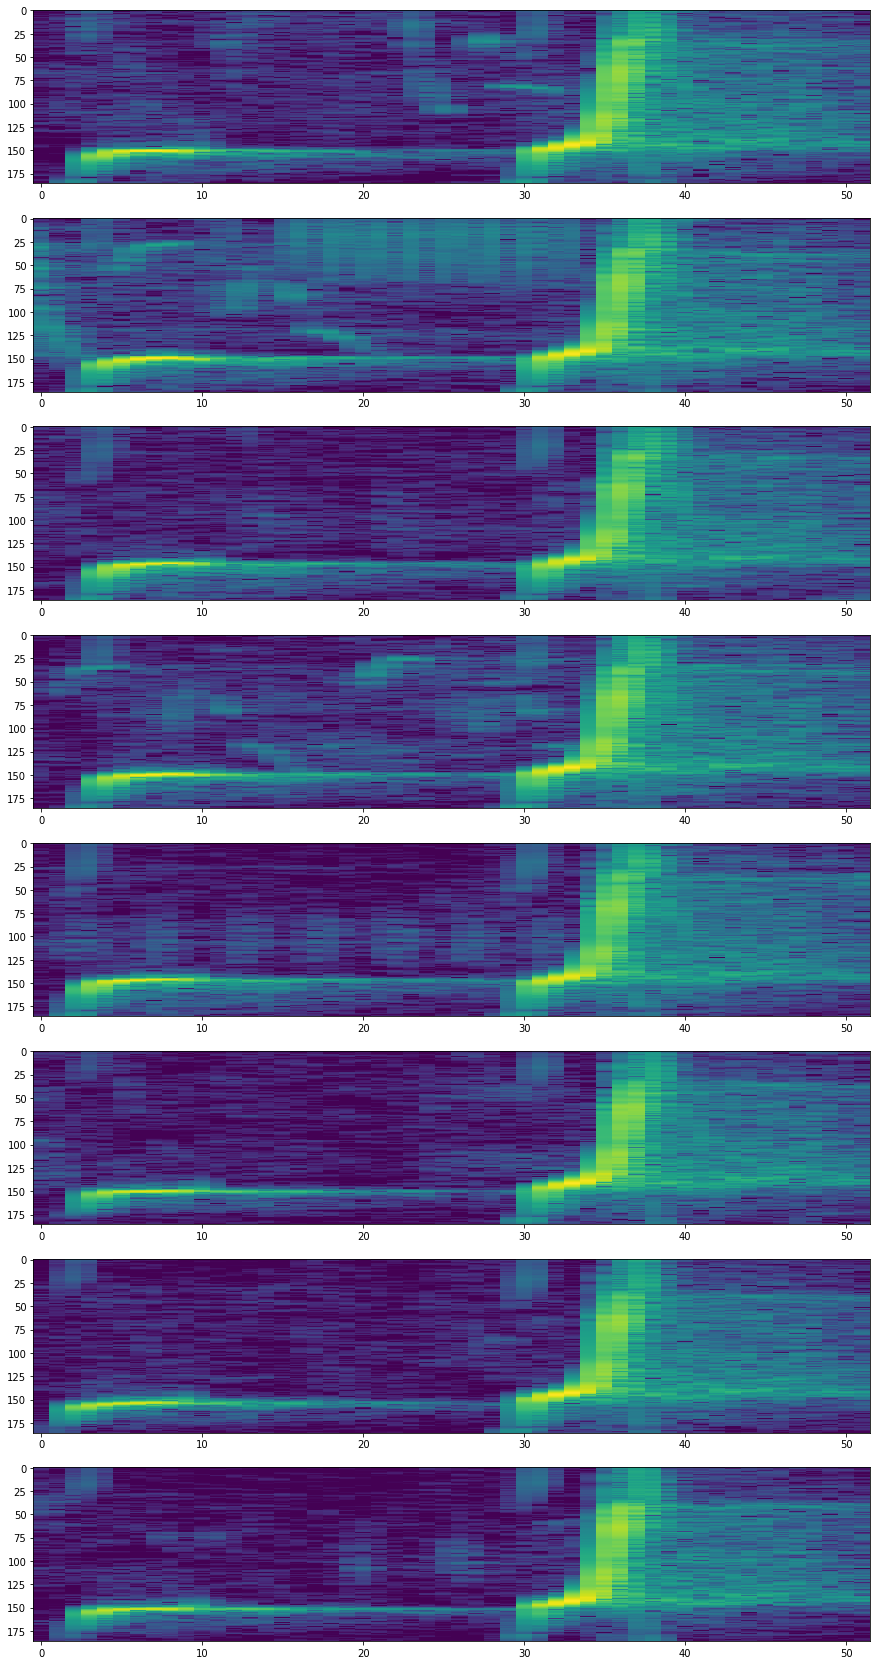

In [85]:
avg_template=0
fig, axes = plt.subplots(len(df.x),1,figsize=(15,30))
for i in range(len(df)):
    avg_template = avg_template + im[r[1]+df.x[i]:r[1]+df.x[i]+imCrop.shape[0],df.y[i]:df.y[i]+imCrop.shape[1]]
    axes[i].imshow(im[r[1]+df.x[i]:r[1]+df.x[i]+imCrop.shape[0],df.y[i]:df.y[i]+imCrop.shape[1]],interpolation='nearest',aspect='auto')

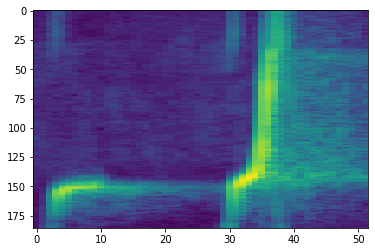

In [86]:
plt.imshow(avg_template,interpolation='nearest',aspect='auto')

In [87]:
#Upload the field data
wav_loc = "./Call_count_data/7550_20180615_064302_Site8_0709.wav"
rate, data1= wavfile.read(wav_loc)
data1 = data1/32768
mytime = np.arange(0, len(data1)/rate, 1/rate)
len(mytime)==len(data1)
data1 = data1.sum(axis=1) / 2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  This is separate from the ipykernel package so we can avoid doing imports until


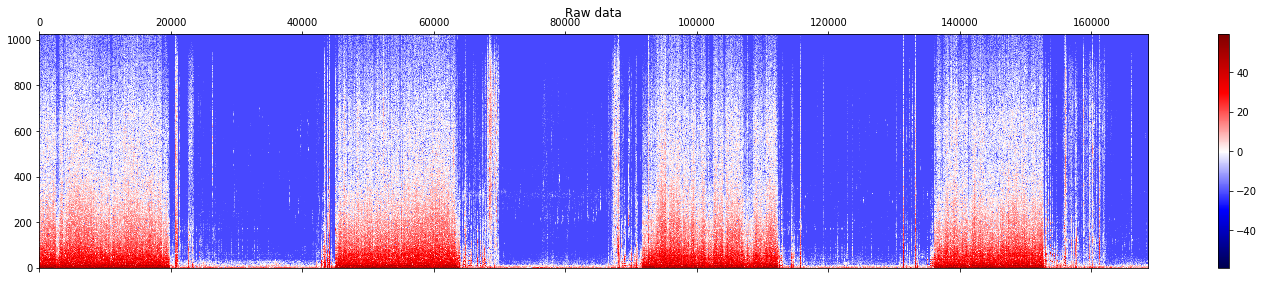

In [88]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data1)
y_pad = librosa.util.fix_length(data1,n + n_fft //2)
data1_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data1_stft_db = _amp_to_db(np.abs(data1_stft))# convert to dB
plot_spectrogram(data1_stft_db, title='Raw data')

In [93]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
bottom=np.min(df.x)-10
top=np.max(df.x)+20
image = data1_stft_db[120:215,:]

In [94]:
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(image,avg_template,5)
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.52)
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000, hop_length=hop_length)

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/templmatch.cpp:1109: error: (-215:Assertion failed) _img.size().height <= _templ.size().height && _img.size().width <= _templ.size().width in function 'matchTemplate'


In [ ]:
df=pd.DataFrame({'times_sec':call_times,'x':x,'y':y,'corr':result[x,y]});
df=df.sort_values('times_sec')
idx=np.where(np.diff(call_times)>0.03)
df=df.loc[(np.diff(np.append(df.times_sec,np.inf))>0.03)].copy()
df=df.reset_index(drop=True)
df['times_min'] = np.array([str(timedelta(seconds=s)) for s in df.times_sec])

df

In [ ]:
#########################################################
#####Tested up to here###################################
#########################################################

In [ ]:
#Upload the field data
wav_loc = "./Call_count_data/7550_20180615_064302_Site8_0709.wav"
rate, data1= wavfile.read(wav_loc)
data1 = data1/32768
mytime = np.arange(0, len(data1)/rate, 1/rate)
len(mytime)==len(data1)

In [ ]:
data1 = data1.sum(axis=1) / 2

In [ ]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data1)
y_pad = librosa.util.fix_length(data1,n + n_fft //2)
data1_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data1_stft_db = _amp_to_db(np.abs(data1_stft))# convert to dB
plot_spectrogram(data1_stft_db, title='Raw data')

In [ ]:
#Define the template as the 'white' portion of a bobwhite call
template_begins = librosa.time_to_frames(1764, sr=rate, hop_length=hop_length)
template_ends = librosa.time_to_frames(1767, sr=rate, hop_length=hop_length)

template1=data1_stft_db[135:205,template_begins:template_ends]
plot_spectrogram(template1,title='Template')

In [ ]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
image = data1_stft_db[120:215,:]

In [ ]:
import cv2
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(image,template1,5)

In [ ]:
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.52)

In [ ]:
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000, hop_length=hop_length)
sorted(call_times)

In [ ]:
tick_hms = np.array([str(timedelta(seconds=s)) for s in (call_times)])
dataset = pd.DataFrame({'Call Time (s)':tick_hms,'Cross-correlation':result[x,y]})
dataset

In [ ]:
avg_template = 0

In [ ]:
i=3

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]], cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
avg_template = avg_template + image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]]

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(avg_template, cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
#Upload the field data
wav_loc = "./Call_count_data/Call_count_data/7550_20180613_064302_Site8_0711.wav"
rate, data2= wavfile.read(wav_loc)
data2 = data2/32768
mytime = np.arange(0, len(data2)/rate, 1/rate)
len(mytime)==len(data2)

In [ ]:
data2 = data2.sum(axis=1) / 2

In [ ]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data2)
y_pad = librosa.util.fix_length(data2,n + n_fft //2)
data2_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data2_stft_db = _amp_to_db(np.abs(data2_stft))# convert to dB
plot_spectrogram(data2_stft_db, title='Raw Spectrogram')

In [ ]:
#Define the template as the 'white' portion of a bobwhite call
template_begins = librosa.time_to_frames(1759, sr=rate, hop_length=hop_length)
template_ends = librosa.time_to_frames(1761, sr=rate, hop_length=hop_length)

template2=data2_stft_db[125:204,template_begins:template_ends]
plot_spectrogram(template2,title='Template')

In [ ]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
image = data2_stft_db[120:215,:]

In [ ]:
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(image,avg_template,5)

In [ ]:
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.55)

In [ ]:
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000)
sorted(call_times)

In [ ]:
tick_hms = np.array([str(timedelta(seconds=s)) for s in sorted(call_times)])
dataset = pd.DataFrame({'Call Time (s)':tick_hms,'Cross-correlation':result[x,y]})
dataset

In [ ]:
y[0]

In [ ]:
i=0

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]], cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
avg_template = avg_template + image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]]

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(avg_template, cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
#Upload the field data
wav_loc = "./Call_count_data/Call_count_data/7550_20180619_064402_Site8_0709.wav"
rate, data= wavfile.read(wav_loc)
data = data/32768
mytime = np.arange(0, len(data)/rate, 1/rate)
len(mytime)==len(data)

In [ ]:
data = data.sum(axis=1) / 2

In [ ]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data)
y_pad = librosa.util.fix_length(data,n + n_fft //2)
data_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data_stft_db = _amp_to_db(np.abs(data_stft))# convert to dB
plot_spectrogram(data_stft_db, title='Raw Spectrogram')

In [ ]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
image = data_stft_db[120:215,:]

In [ ]:
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(image,avg_template,5)

In [ ]:
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.55)

In [ ]:
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000)
sorted(call_times)

In [ ]:
tick_hms = np.array([str(timedelta(seconds=s)) for s in sorted(call_times)])
dataset = pd.DataFrame({'Call Time (s)':tick_hms,'Cross-correlation':result[x,y]})
dataset

In [ ]:
avg_template = 0

In [ ]:
i=5

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]], cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
avg_template = avg_template + image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]]

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(avg_template, cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
#Upload the field data
wav_loc = "./Call_count_data/Call_count_data/ORR-BWQ_20180615_074302.wav"
rate, data= wavfile.read(wav_loc)
data = data/32768
mytime = np.arange(0, len(data)/rate, 1/rate)
len(mytime)==len(data)

In [ ]:
data = data.sum(axis=1) / 2

In [ ]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data)
y_pad = librosa.util.fix_length(data,n + n_fft //2)
data_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data_stft_db = _amp_to_db(np.abs(data_stft))# convert to dB
plot_spectrogram(data_stft_db, title='Raw Spectrogram')

In [ ]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
image = data_stft_db[120:215,:]

In [ ]:
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(image,avg_template,5)

In [ ]:
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.5)

In [ ]:
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000)
sorted(call_times)

In [ ]:
tick_hms = np.array([str(timedelta(seconds=s)) for s in sorted(call_times)])
dataset = pd.DataFrame({'Call Time (s)':tick_hms,'Cross-correlation':result[x,y]})
dataset

In [ ]:
i=1

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]], cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
#Upload the field data
wav_loc = "./Call_count_data/Call_count_data/7818-RR-PCN_20181209_180002.wav"
rate, data= wavfile.read(wav_loc)
data = data/32768
mytime = np.arange(0, len(data)/rate, 1/rate)
len(mytime)==len(data)

In [ ]:
data = data.sum(axis=1) / 2

In [ ]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data)
y_pad = librosa.util.fix_length(data,n + n_fft //2)
data_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data_stft_db = _amp_to_db(np.abs(data_stft))# convert to dB
plot_spectrogram(data_stft_db, title='Raw Spectrogram')

In [ ]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
image = data_stft_db[120:215,:]

In [ ]:
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(image,avg_template,5)

In [ ]:
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.4)

In [ ]:
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000)
sorted(call_times)

In [ ]:
tick_hms = np.array([str(timedelta(seconds=s)) for s in sorted(call_times)])
dataset = pd.DataFrame({'Call Time (s)':tick_hms,'Cross-correlation':result[x,y]})
dataset

In [ ]:
np.savetxt('bobwhite_editedavgtemplate.txt', avg_template, fmt='%.18g', delimiter=',')

In [ ]:
template_backup=avg_template

In [ ]:
#Upload the field data
wav_loc = "./Call_count_data/Call_count_data/7550_20180627_064602_Site5_0740.wav"
rate, data= wavfile.read(wav_loc)
data = data/32768
mytime = np.arange(0, len(data)/rate, 1/rate)
len(mytime)==len(data)

In [ ]:
data = data.sum(axis=1) / 2

In [ ]:
#Plot the spectrogram after the bandpass
n_fft = 2048
hop_length = 512
win_length = 2048

n=len(data)
y_pad = librosa.util.fix_length(data,n + n_fft //2)
data_stft = librosa.stft(y_pad, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
data_stft_db = _amp_to_db(np.abs(data_stft))# convert to dB
plot_spectrogram(data_stft_db, title='Raw Spectrogram')

In [ ]:
#Select a region of the spectrogram to be search--here, 10 pixels above or below the template
image = data_stft_db[105:240,:]

In [ ]:
#"Method: \n 0: SQDIFF \n 1: SQDIFF NORMED \n 2: TM CCORR \n 3: TM CCORR NORMED \n 4: TM COEFF \n 5: TM COEFF NORMED"
#Ten times fast than second method?
result = cv2.matchTemplate(image,avg_template,5)

In [ ]:
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(result, size=5, mode='reflect')
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(result, min_distance=5,threshold_abs = 0.54)

In [ ]:
#detection times in bob1.wave
x=coordinates[:,0]
y=coordinates[:,1]
call_times = librosa.frames_to_time(y, sr=24000)
sorted(call_times)

In [ ]:
tick_hms = np.array([str(timedelta(seconds=s)) for s in sorted(call_times)])
dataset = pd.DataFrame({'Call Time (s)':tick_hms,'Cross-correlation':result[x,y]})
dataset

In [ ]:
i=0

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]], cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
avg_template = avg_template + image[x[i]:x[i]+template1.shape[0],y[i]:y[i]+template1.shape[1]]

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax.imshow(avg_template, cmap=plt.cm.gray, interpolation='nearest', aspect='auto',origin='lower')
ax.set_axis_off()
ax.set_title('image')
# highlight matched region
#hcoin, wcoin = template.shape
#rect = plt.Rectangle((x[0], y[0]), wcoin, hcoin, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

plt.show()

In [ ]:
plot_spectrogram(avg_template,title='avg')

In [ ]:
recovered_signal = librosa.istft(avg_template, hop_length=hop_length, win_length=win_length,length = n)